In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statistics
import mysql.connector
import networkx as nx
import numpy as np
import csv
import pandas as pd

In [2]:
# Establish database connection
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()

# Papers Analysis

In [3]:
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = TRUE")
total_paper_without_references = cursor.fetchone()[0]
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = FALSE and p.ReferenceCount is not null")
total_paper_with_references = cursor.fetchone()[0]
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = FALSE AND p.ReferenceCount > 0")
total_paper_at_least_one = cursor.fetchone()[0]
print(f"Total papers: {total_paper_without_references + total_paper_with_references}")
print(f"Paper references: {total_paper_without_references}")
print(f"Papers: {total_paper_with_references}")
print(f"Papers with at least one reference: {total_paper_at_least_one}")

Total papers: 467620
Paper references: 439587
Papers: 28033
Papers with at least one reference: 27824


In [92]:
cursor.execute("SELECT count(*) FROM Authors a")
total_authors = cursor.fetchone()[0]
cursor.execute("SELECT count(distinct a.AuthorID) from Papers p, Authors a, authoredBy b WHERE p.leaf = False and p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID")
total_authors_with_references = cursor.fetchone()[0]
print(f"Total authors: {total_authors}")
print(f"Total authors with references: {total_authors_with_references}")
print(f"Avg Authors per paper: {total_authors_with_references/total_paper_with_references}")


Total authors: 541314
Total authors with references: 64450
Avg Authors per paper: 2.2990760888952306


2.3039720713731575
1.0


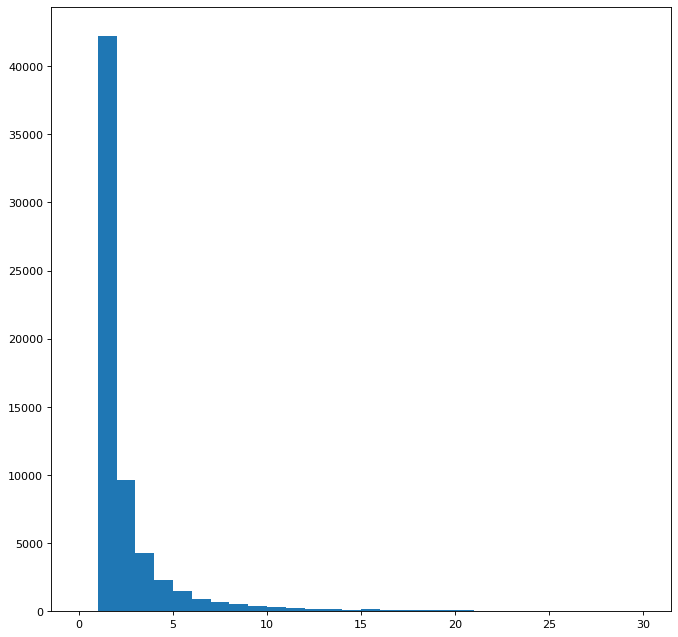

In [106]:
cursor.execute("SELECT count(*) from Papers p, Authors a, authoredBy b WHERE p.leaf = False and p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID GROUP BY a.AuthorID, a.Name")
author_counts = sorted([author_count[0] for author_count in cursor.fetchall()])
print(statistics.mean(author_counts))
print(statistics.median(author_counts))
figure(figsize=(10, 10),dpi=80)
plt.hist(author_counts, bins=30, range=(0,30))
plt.show()

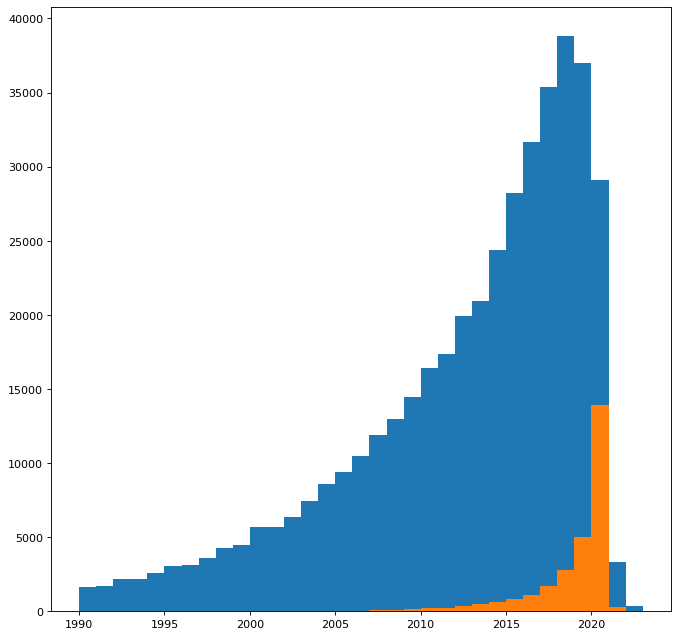

In [76]:
cursor.execute("SELECT p.Pub_Year FROM Papers p")
year_distribution_all = [pub_year[0] for pub_year in cursor.fetchall() if pub_year[0]]
cursor.execute("SELECT p.Pub_Year FROM Papers p WHERE p.Leaf = FALSE")
year_distribution = [pub_year[0] for pub_year in cursor.fetchall() if pub_year[0]]
figure(figsize=(10, 10), dpi=80)
plt.hist(year_distribution_all, bins=33, range=(1990,2023))
plt.hist(year_distribution, bins=33, range=(1990,2023))
plt.show()

In [4]:
cursor.execute("SELECT p.journalName,COUNT(distinct p.PaperID) FROM Papers p group by p.journalName")
journalDistribution = cursor.fetchall()

In [5]:
journalDistribution = sorted(journalDistribution, key=lambda tup: tup[1], reverse=True)
journalDistribution

[('', 27863),
 ('ArXiv', 3236),
 ('IEEE Transactions on Pattern Analysis and Machine Intelligence', 1135),
 ('IEEE Transactions on Image Processing', 837),
 ('Pattern Recognit.', 746),
 ('International Journal of Computer Vision', 631),
 ('IEEE Trans. Pattern Anal. Mach. Intell.', 495),
 ('Pattern Recognit. Lett.', 430),
 ('IEEE Transactions on Medical Imaging', 411),
 ('IEEE transactions on image processing : a publication of the IEEE Signal Processing Society',
  306),
 ('Image Vis. Comput.', 292),
 ('Comput. Vis. Image Underst.', 277),
 ('2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)',
  266),
 ('2013 IEEE Conference on Computer Vision and Pattern Recognition', 265),
 ('2014 IEEE Conference on Computer Vision and Pattern Recognition', 265),
 ('2012 IEEE Conference on Computer Vision and Pattern Recognition', 264),
 ('J. Mach. Learn. Res.', 248),
 ('CVPR 2011', 235),
 ('Nature', 234),
 ('2013 IEEE International Conference on Computer Vision', 232),
 ('IEEE Tr

# Reference Analysis

In [63]:
cursor.execute("SELECT AVG(p.ReferenceCount) FROM Papers p WHERE p.Leaf = FALSE")
avg_references = float(cursor.fetchone()[0])
cursor.execute("SELECT p.ReferenceCount FROM Papers p WHERE p.Leaf = FALSE")
reference_count = statistics.median([ref[0] for ref in cursor.fetchall()])
cursor.execute("SELECT MIN(p.ReferenceCount), MAX(p.ReferenceCount) FROM Papers p WHERE p.Leaf = FALSE")
borders = cursor.fetchall()[0]
print(f"Average references: {avg_references}")
print(f"Median references: {reference_count}")
print(f"Min: {borders[0]}")
print(f"Max: {borders[1]}")

Average references: 40.1926
Median references: 36
Min: 0
Max: 1579


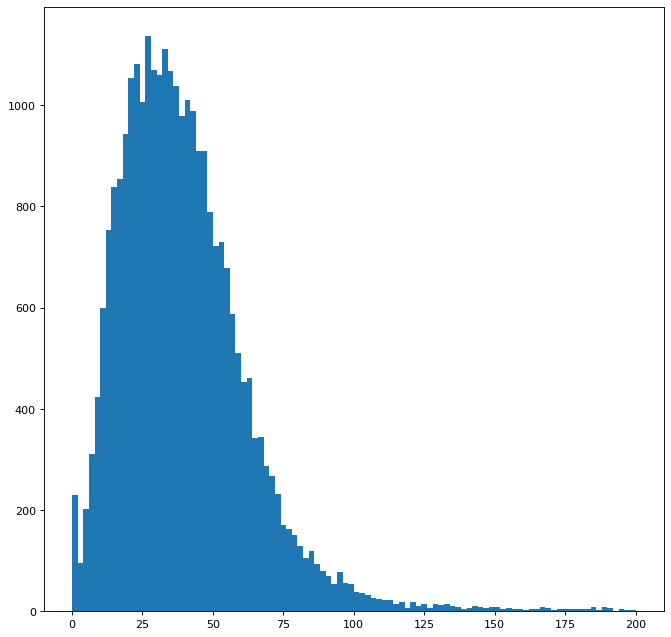

In [53]:
cursor.execute("SELECT p.ReferenceCount FROM Papers p WHERE p.Leaf = FALSE")
ref_distribution = [item[0] for item in cursor.fetchall()]
figure(figsize=(10, 10), dpi=80)
plt.hist(ref_distribution, bins=100, range=(0,200))
plt.show()

# Graph Analysis

In [6]:
cursor.execute("SELECT r.ReferencedByID,r.ReferenceID FROM referencedBy r")
references_all = cursor.fetchall()
cursor.execute("SELECT p.PaperID FROM Papers p")
papers_all = [paper_id[0] for paper_id in cursor.fetchall()]

In [7]:
G = nx.DiGraph()
G.add_nodes_from(papers_all)
G.add_edges_from(references_all)
nx.info(G)

/tmp/ipykernel_7085/1159736360.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'DiGraph with 467620 nodes and 1415451 edges'

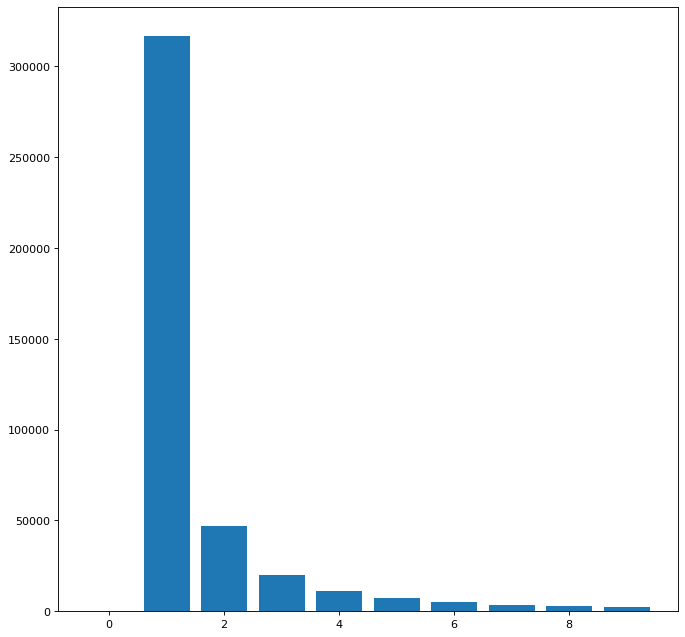

In [36]:
density = nx.density(G)
degree_hist = nx.degree_histogram(G)
figure(figsize=(10, 10), dpi=80)
plt.bar(range(len(degree_hist[0:10])), degree_hist[0:10])
plt.show()

In [78]:
print("Strong Connectivity")
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G)}")
print("Weak Connectivity")
print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
weak_components_length = []
weak_components = []
for wc in nx.weakly_connected_components(G):
    weak_components_length.append(len(wc))
    weak_components.append(wc)
print(f"Unique sizes of weak components: {sorted(set(weak_components_length), reverse=True)}")


Strong Connectivity
Number of strongly connected components: 467620
Weak Connectivity
Number of weakly connected components: 398
Unique sizes of weak components: [465702, 130, 80, 43, 32, 29, 28, 27, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [95]:
len(weak_components[5])
weak_components_length

[465702,
 12,
 130,
 4,
 1,
 14,
 1,
 80,
 13,
 6,
 1,
 9,
 23,
 1,
 1,
 6,
 1,
 17,
 21,
 1,
 28,
 80,
 1,
 7,
 4,
 22,
 32,
 14,
 16,
 11,
 24,
 10,
 1,
 8,
 13,
 8,
 1,
 1,
 14,
 20,
 28,
 16,
 43,
 10,
 1,
 9,
 15,
 11,
 18,
 19,
 1,
 2,
 14,
 1,
 13,
 22,
 15,
 1,
 1,
 16,
 14,
 3,
 27,
 14,
 7,
 12,
 29,
 5,
 11,
 22,
 19,
 5,
 17,
 14,
 29,
 8,
 12,
 11,
 8,
 18,
 12,
 6,
 5,
 3,
 10,
 4,
 27,
 8,
 2,
 5,
 10,
 3,
 14,
 12,
 27,
 23,
 6,
 19,
 7,
 7,
 7,
 2,
 5,
 16,
 6,
 7,
 4,
 12,
 15,
 2,
 10,
 16,
 4,
 3,
 1,
 2,
 11,
 12,
 4,
 12,
 1,
 1,
 1,
 6,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 14,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 10,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,


KeyboardInterrupt: 

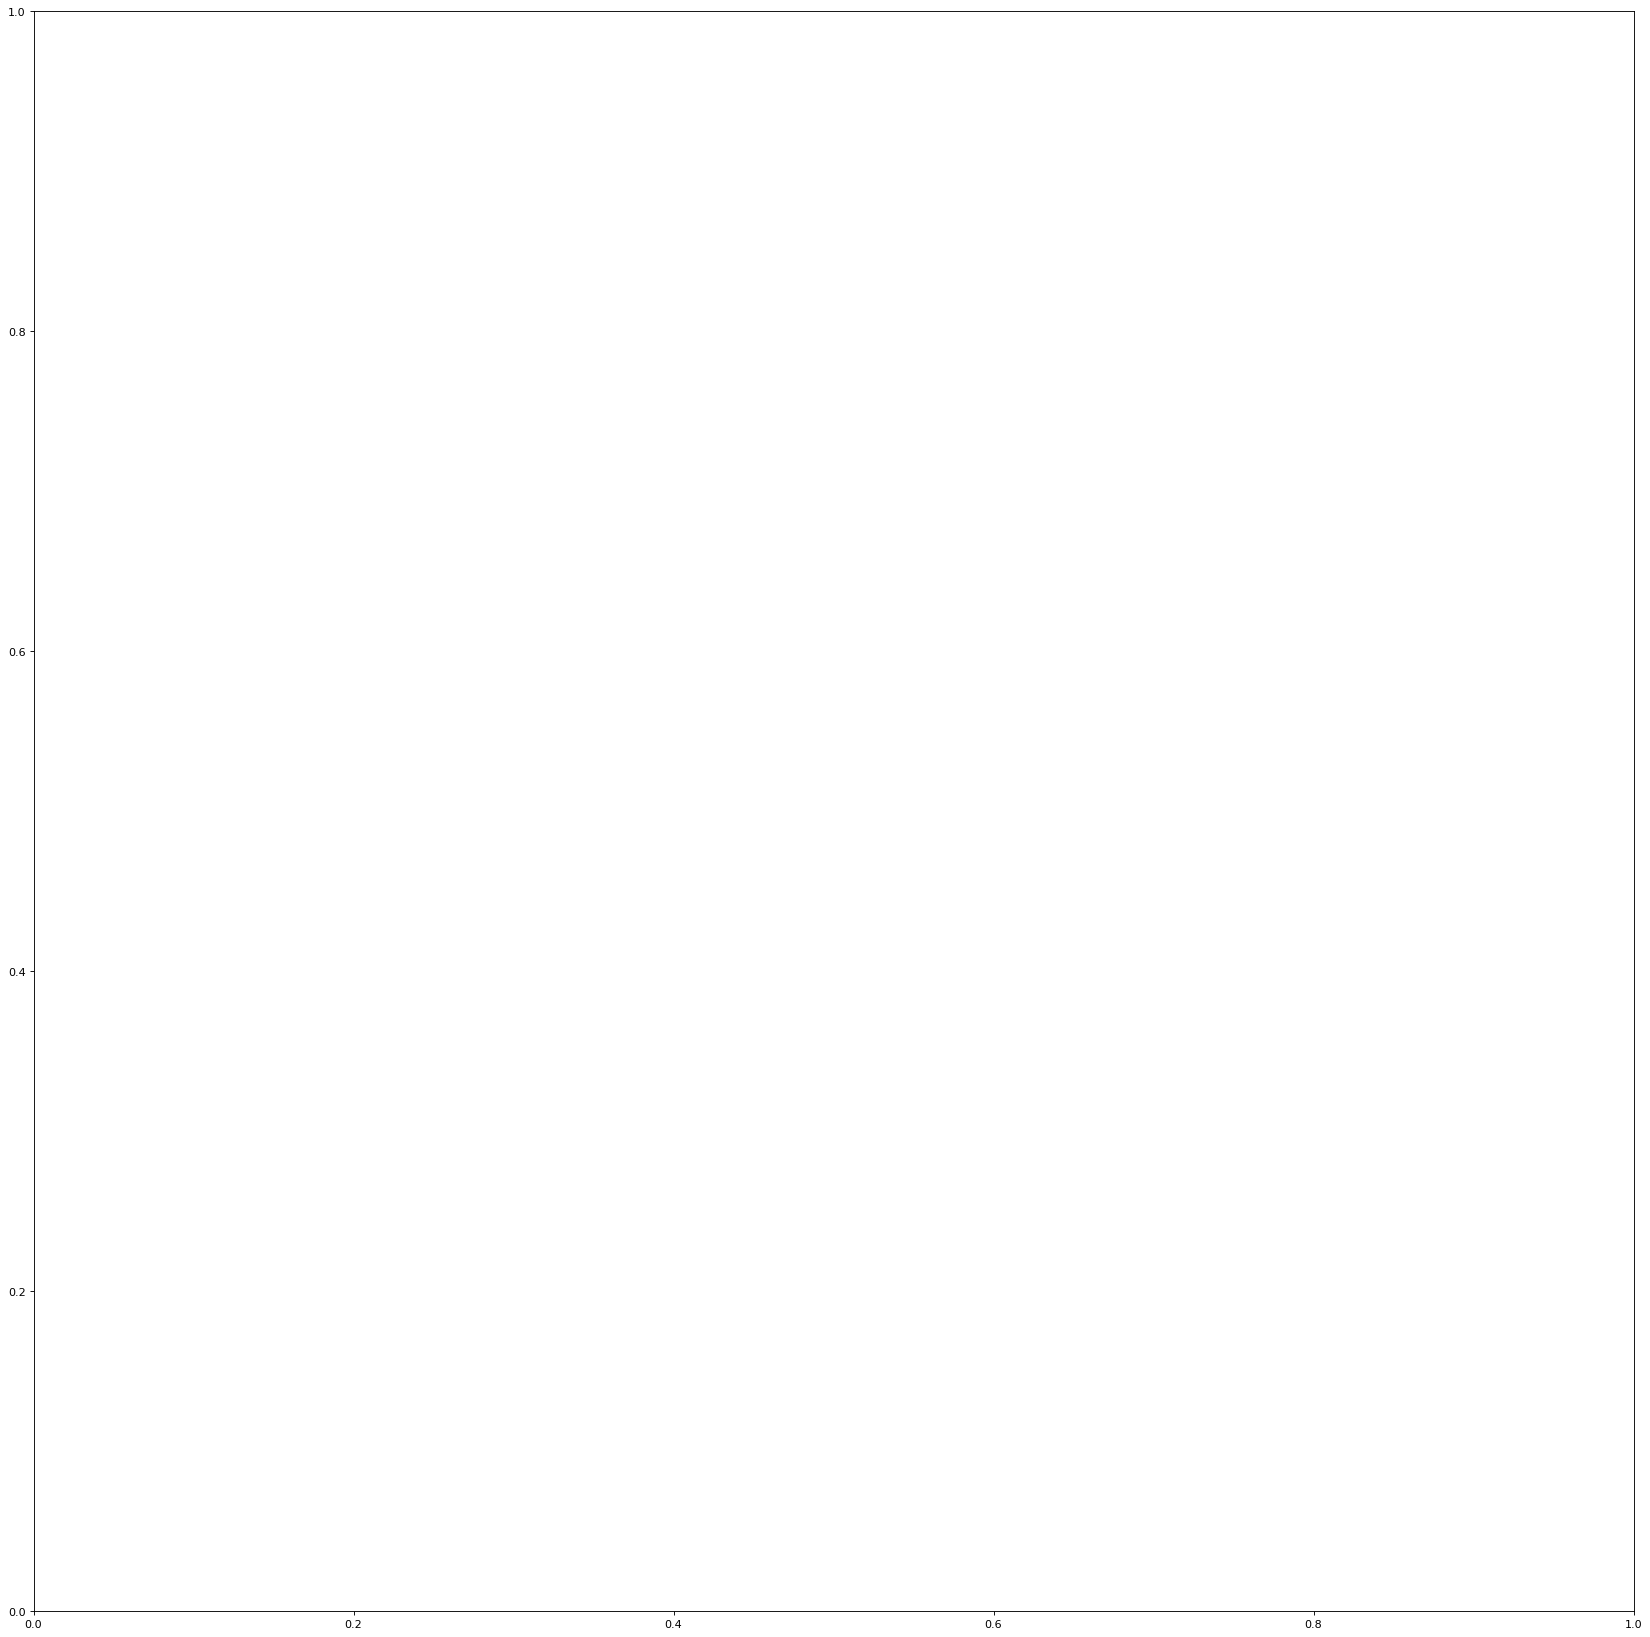

In [103]:
figure(figsize=(20, 20), dpi=80)
nx.draw(G.subgraph(weak_components[0]), with_labels=True)

In [102]:
weak_components[2]

{'00476838b45d5b3f60fdf06862a4ca8d27dd8367',
 '01f4b44581ac1a5ff5ebe478880bc7a62c90c1d5',
 '044fac84b9d17f92ef61c78e2b1875fc9ebecd44',
 '0737094480812241ee658e6098a595737752e1aa',
 '093eefe80dda51ce76ad45983356644ac9f7435d',
 '0a06fd387217f774173f15bcb90d4e59b059c4fc',
 '0a101e5305b533754c89aa1c0bb17b566adfe303',
 '0ad170bf0f17943c49187b99c0c333a1f7b7d365',
 '0c597bfdc322cc52a34713a9a9eaaaa394837f42',
 '0c643bb36feab62b2c7aa9e3c7a09a9f81ea672f',
 '0fa10e31a3ac2f8bb32058dcd0c76550352fb244',
 '110d81a1a719e3f92fd1879434f5f417f731d76e',
 '1111121b3fd3953b7464e8d912b3b072ddf37',
 '1111135512e58d58a4212a09531d6e62e83bb',
 '1111174f80b3f4ead4d14bcba56716a72e9b6',
 '11111a9deb59907b54a8db42939beec348b99',
 '11111d7af82a20b854454a1352b2f17e00829',
 '1320dee5ccc34c90c638d24fb7f69e16b8734da9',
 '13c393db70238530c2d20d136288e6af04b32c16',
 '17b6fd63db71e53613381c168f7b194e68b380a1',
 '17cfcd6627eeb7adcc45948724aeac11f4990858',
 '18750b4840625e60bfcec072fabb7189231334b6',
 '18a41aa27cbe4c2b444c829

<generator object weakly_connected_components at 0x7fa6eb9f6ff0>

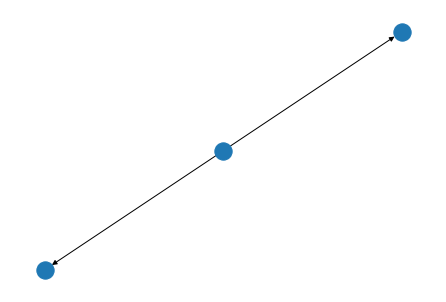

In [60]:
G2 = nx.DiGraph()
G2.add_edges_from([(1,2),(1,3)])
nx.draw(G2)

In [62]:
l = []
for x in nx.weakly_connected_components(G2):
    l.append(x)

In [63]:
l

[{1, 2, 3}]

In [2]:
from scholarly import scholarly, ProxyGenerator

pg = ProxyGenerator()
success = pg.FreeProxies()


FreeProxyException: Request to www.sslproxies.org failed

In [3]:
from fp.fp import FreeProxy
proxy = FreeProxy().get()

In [4]:
proxy

'http://116.203.199.47:8080'

In [9]:
scholarly.use_proxy(proxy)

StopIteration: 